In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import netCDF4 as nc
import xarray as xr
import scipy.ndimage
import scipy as sp
import alphashape
from scipy import interpolate
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')


In [126]:
# Data from: Franke, Steven; Jansen, Daniela; Drews, Reinhard; Eisen, Olaf (2020): 
# Ice thickness from the coast of Dronning Maud Land (Antarctica), recorded 2018/19 
# with the AWI UWB radar system. Alfred Wegener Institute, Helmholtz Centre for Polar 
# and Marine Research, Bremerhaven, PANGAEA, https://doi.pangaea.de/10.1594/PANGAEA.911868 
# (DOI registration in progress)

# DerwaelData = pd.read_csv('../Data/Franke-etal_2020_UWB-iceDML.tab', delimiter="    ")

# Lat Lon Conversion from Vjeran:
DerwaelData = pd.read_csv('../Data/IceRiseClara_xyH.txt', delimiter=" ")

# Elmer input data (originally from BedMachine)
ds = nc.Dataset('/Users/clara.henry/Documents/Derwael/Code/DerwaelBCs.nc')
bedrock_old = np.array(ds.variables['bedrock'][:])
upper_surface_old = np.array(ds.variables['zs0'][:])
lower_surface_old = np.array(ds.variables['zb0'][:])
X = np.array(ds.variables['x'][:])
Y = np.array(ds.variables['y'][:])


In [127]:
# Flip arrays for consistency

bedrock_old = np.flipud(bedrock_old)
upper_surface_old = np.flipud(upper_surface_old)
lower_surface_old = np.flipud(lower_surface_old)
Y = Y[::-1]

DerwaelData

,X,Y,H
0,-55534.490946,2.068965e+06,352.92
1,-55548.401583,2.068971e+06,352.95
2,-55562.326740,2.068976e+06,353.77
3,-55576.244752,2.068982e+06,353.67
4,-55590.159229,2.068987e+06,354.58
...,...,...,...
130187,809494.980692,1.818957e+06,1113.96
130188,809484.567259,1.818945e+06,1115.73
130189,809474.561370,1.818935e+06,1115.27
130190,809464.148060,1.818924e+06,1118.03


In [128]:
DerwaelData['RollingH200'] = DerwaelData.H.rolling(200).mean()
DerwaelData

,X,Y,H,RollingH200
0,-55534.490946,2.068965e+06,352.92,NaN
1,-55548.401583,2.068971e+06,352.95,NaN
2,-55562.326740,2.068976e+06,353.77,NaN
3,-55576.244752,2.068982e+06,353.67,NaN
4,-55590.159229,2.068987e+06,354.58,NaN
...,...,...,...,...
130187,809494.980692,1.818957e+06,1113.96,800.14805
130188,809484.567259,1.818945e+06,1115.73,802.35145
130189,809474.561370,1.818935e+06,1115.27,804.56430
130190,809464.148060,1.818924e+06,1118.03,806.79075


In [129]:
# Add column to DerwaelData to store surface values

DerwaelData['zs'] = 0
DerwaelData['zb'] = 0

# Define the function for interpolating data from the 2D grid

f = interpolate.interp2d(X, Y, upper_surface_old, kind='linear')

for i in range(len(DerwaelData)):
    DerwaelData['zs'][i] = f(DerwaelData['X'][i], DerwaelData['Y'][i])

DerwaelData['zb'] = DerwaelData['zs'] - DerwaelData['H']

DerwaelData['zb'].max()


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_24946/3203703208.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DerwaelData['zs'][i] = f(DerwaelData['X'][i], DerwaelData['Y'][i])


-44.26

In [130]:
# Add column to DerwaelData to store base values from BedMachine

DerwaelData['zb_bedmachine'] = 0
DerwaelData['bed_subtraction'] = 0

f2 = interpolate.interp2d(X, Y, bedrock_old, kind='linear')

for i in range(len(DerwaelData)):
    DerwaelData['zb_bedmachine'][i] = f2(DerwaelData['X'][i], DerwaelData['Y'][i])

DerwaelData['bed_subtraction'] = DerwaelData['zb_bedmachine'] - DerwaelData['zb']
DerwaelData['bed_subtraction']

/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_24946/2855197769.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DerwaelData['zb_bedmachine'][i] = f2(DerwaelData['X'][i], DerwaelData['Y'][i])


0          -2.737293
1          -2.707293
2          -1.887293
3          -1.987293
4          -1.077293
             ...    
130187    640.702165
130188    642.472165
130189    642.012165
130190    644.772165
130191    645.872165
Name: bed_subtraction, Length: 130192, dtype: float64

/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_24946/52239915.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(CS, ticks=[300, 400])


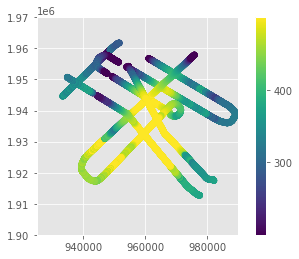

In [131]:
fig, ax = plt.subplots(1, 1)
ax.set_xlim(0.925e6,0.99e6)
ax.set_ylim(1.9e6,1.97e6)
ax.axis('scaled')

CS = ax.scatter(DerwaelData["X"], DerwaelData["Y"], c=DerwaelData["H"], vmin=200.0, vmax=500.0) 
fig.colorbar(CS, ticks=[300, 400])


In [132]:
# Interpolate bed data

x = np.linspace(920500.0, 998000.0, 156)
y = np.linspace(1880000.0, 1966000.0, 173)
grid_x, grid_y = np.mgrid[920500.0:998000.0:156j, 1880000.0:1966000.0:173j]
thickness = scipy.interpolate.griddata((DerwaelData["X"], DerwaelData["Y"]), DerwaelData["H"], (grid_x, grid_y), method='linear')
thickness

array([[394.81328856, 344.45514375, 373.09520514, ..., 337.09021119,
        331.50443238, 321.24743545],
       [334.36937541, 372.6106072 , 384.62877877, ..., 336.01080103,
        329.40405073, 319.1470538 ],
       [361.51345096, 384.18994388, 388.55773372, ..., 335.37108206,
        327.30366908, 317.04667215],
       ...,
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])

(1900000.0, 1970000.0)

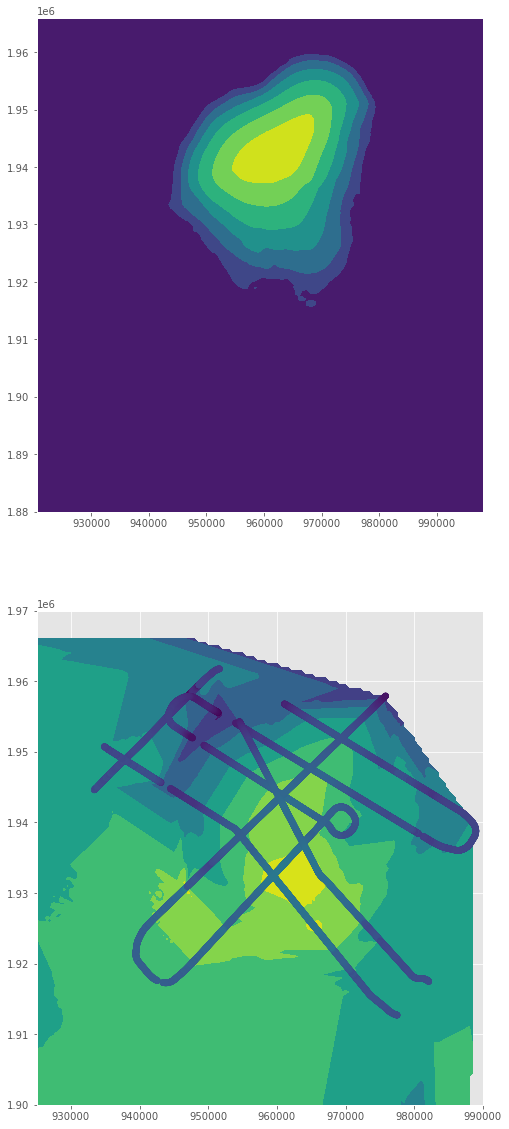

In [133]:
# Plot interpolated data

fig, ax = plt.subplots(2, 1, figsize=(8, 20))
#CS = ax.contourf(grid_x, grid_y, smb_new_dsdt_50)
ax[0].contourf(grid_x, grid_y, upper_surface_old.T)# , levels=np.linspace(-1.0,1.0,500)
ax[1].contourf(grid_x, grid_y, thickness)
ax[1].scatter(DerwaelData["X"], DerwaelData["Y"], c=DerwaelData["H"]) 
ax[1].set_xlim(0.925e6,0.99e6)
ax[1].set_ylim(1.9e6,1.97e6)
#ax[1].axis('scaled')


In [134]:
lowersurface = upper_surface_old - thickness.T

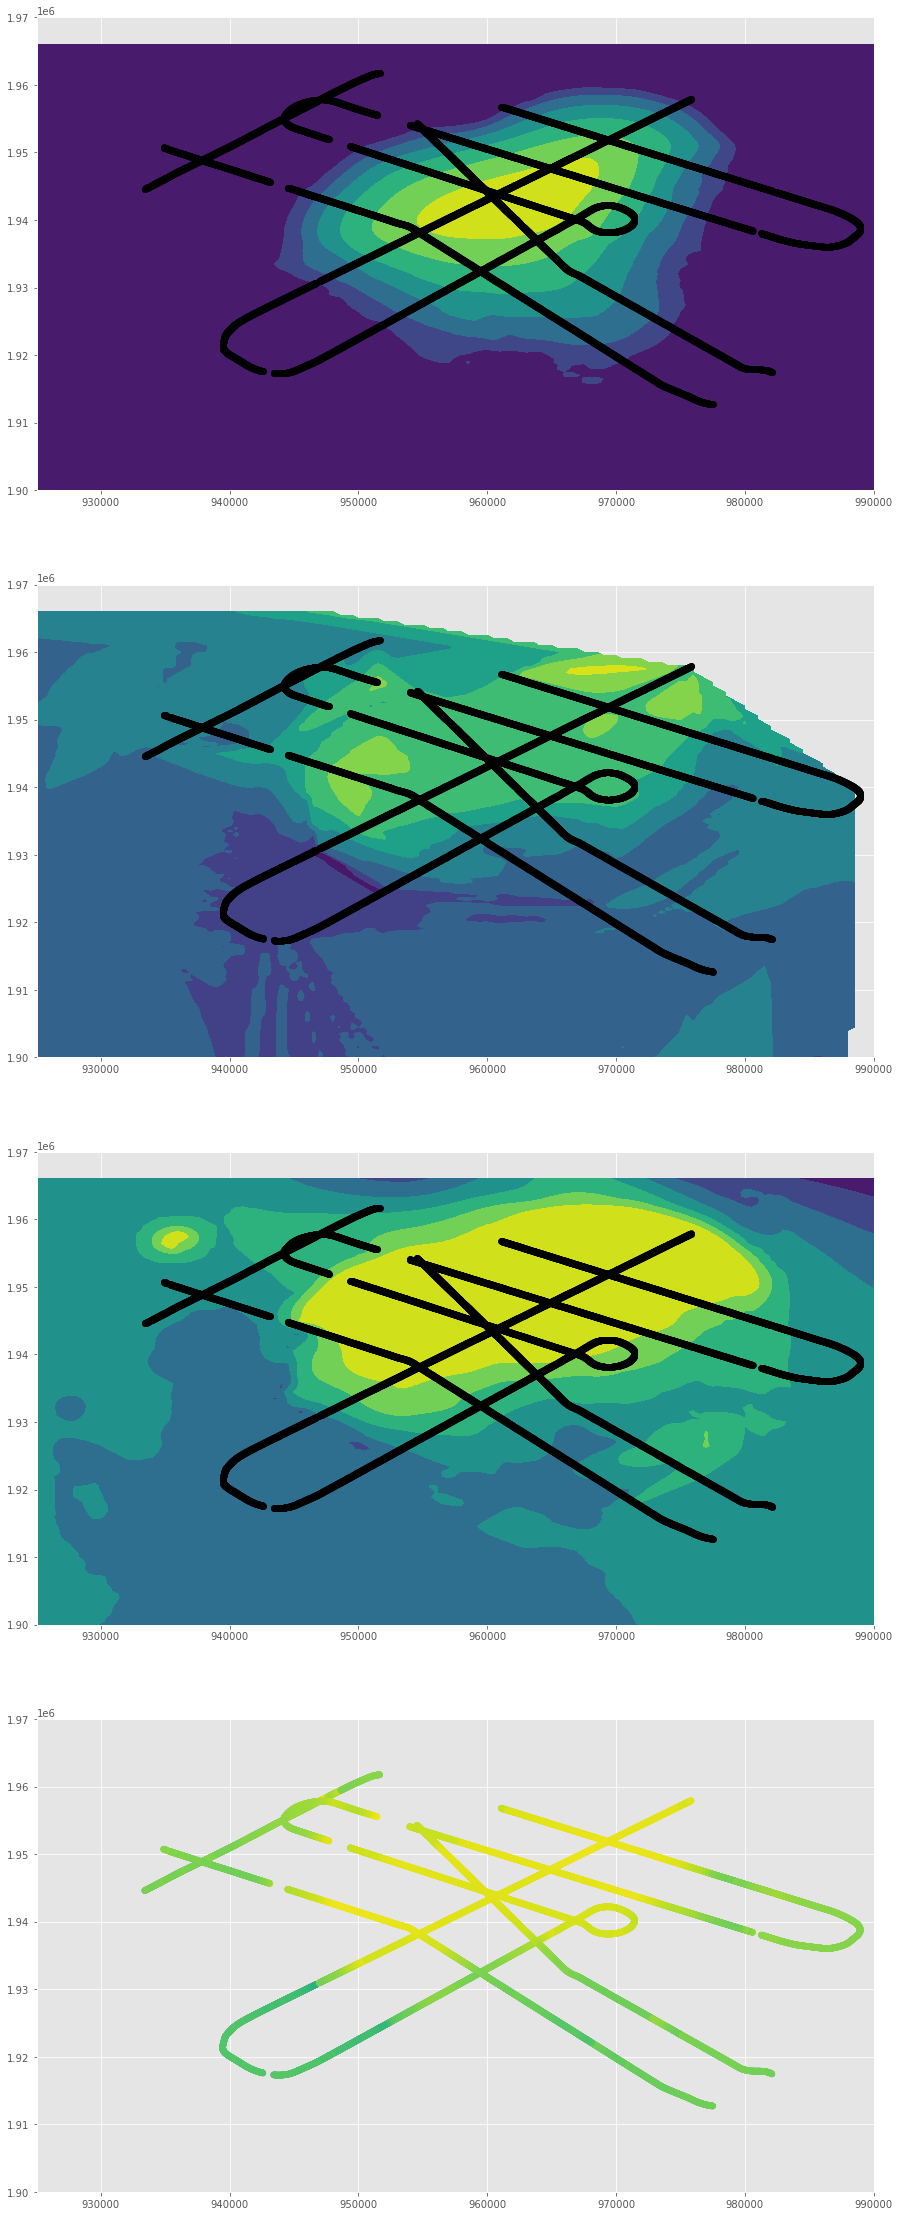

In [135]:
fig, ax = plt.subplots(4, 1, figsize=(15, 40))
#CS = ax.contourf(grid_x, grid_y, smb_new_dsdt_50)
ax[0].contourf(grid_x, grid_y, upper_surface_old.T)
ax[1].contourf(grid_x, grid_y, lowersurface.T) # , levels=np.linspace(-1.0,1.0,500)
ax[0].scatter(DerwaelData["X"], DerwaelData["Y"], c='black', vmin=0, vmax=500) 
ax[1].scatter(DerwaelData["X"], DerwaelData["Y"], c='black', vmin=0, vmax=500) 
#ax[1].scatter(DerwaelData["X"], DerwaelData["Y"], c=DerwaelData["H"], vmin=0, vmax=500, cmap='Reds') 
ax[2].contourf(grid_x, grid_y, bedrock_old.T)
ax[2].scatter(DerwaelData["X"], DerwaelData["Y"], c='black', vmin=0, vmax=500)
ax[3].scatter(DerwaelData["X"], DerwaelData["Y"], c=DerwaelData["zb"], cmap='viridis') 
ax[0].set_xlim(0.925e6,0.99e6)
ax[0].set_ylim(1.9e6,1.97e6)
ax[1].set_xlim(0.925e6,0.99e6)
ax[1].set_ylim(1.9e6,1.97e6)
ax[2].set_xlim(0.925e6,0.99e6)
ax[2].set_ylim(1.9e6,1.97e6)
ax[3].set_xlim(0.925e6,0.99e6)
ax[3].set_ylim(1.9e6,1.97e6)

fig.savefig('InterpolationFigures.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_24946/2393574469.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS)


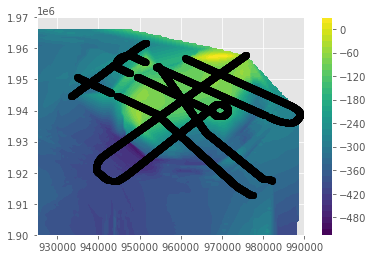

In [139]:
fig, ax = plt.subplots(1, 1)
CS = ax.contourf(grid_x, grid_y, lowersurface.T, levels=50) # , levels=np.linspace(-1.0,1.0,500)
ax.scatter(DerwaelData["X"], DerwaelData["Y"], c='black', vmin=0, vmax=500) 
ax.set_xlim(0.925e6,0.99e6)
ax.set_ylim(1.9e6,1.97e6)
cbar = fig.colorbar(CS)


In [ ]:
fig, ax = plt.subplots()
CS = ax.scatter(DerwaelData["X"], DerwaelData["Y"], c=DerwaelData["zb"], cmap='viridis', vmin= -120, vmax=-80)   
ax.set_xlim(0.925e6,0.99e6)
ax.set_ylim(1.9e6,1.97e6)
cbar = fig.colorbar(CS, extend="min")
cbar.set_label('Bed elevation [m]', size=15)
#fig.savefig('Bed.jpg', format='jpg', dpi=700, bbox_inches = "tight")


In [ ]:
fig, ax = plt.subplots()
CS = ax.scatter(DerwaelData["X"], DerwaelData["Y"], c=DerwaelData["zb"], cmap='viridis', vmin= -120, vmax=-80)   
ax.set_xlim(0.96e6,0.98e6)
ax.set_ylim(1.94e6,1.96e6)
cbar = fig.colorbar(CS, extend="min")
cbar.set_label('Bed elevation [m]', size=15)
#fig.savefig('Bed.jpg', format='jpg', dpi=700, bbox_inches = "tight")


In [ ]:
fig, ax = plt.subplots()
CS = ax.scatter(DerwaelData["X"], DerwaelData["Y"], c=DerwaelData["zb"], cmap='viridis', vmin= -90, vmax=-87)   
ax.set_xlim(0.925e6,0.99e6)
ax.set_ylim(1.9e6,1.97e6)
plt.xlim([969300, 969450])
plt.ylim([1951700, 1952000])
cbar = fig.colorbar(CS, extend="min")
cbar.set_label('Bed elevation [m]', size=15)
#fig.savefig('Bed.jpg', format='jpg', dpi=700, bbox_inches = "tight")


In [ ]:
# Plot the BedMachine bed minus the radar data bed (calculated by subtracting the radar data ice thickness from BedMachien surface)

fig, ax = plt.subplots()
#CS = ax.scatter(DerwaelData["X"], DerwaelData["Y"], c=DerwaelData['zb'], cmap='viridis')   
#CS = ax.scatter(DerwaelData["X"], DerwaelData["Y"], c=DerwaelData['zb_bedmachine'], cmap='viridis')   
CS = ax.scatter(DerwaelData["X"], DerwaelData["Y"], c=DerwaelData['bed_subtraction'], cmap='RdYlBu', vmin=-150, vmax=150)   
ax.set_xlim(0.925e6,0.99e6)
ax.set_ylim(1.9e6,1.97e6)
cbar = fig.colorbar(CS, extend="both")
cbar.set_label('BedMachine bed - radar bed [m]', size=15)
fig.savefig('BedMachineMinusRadarBed.jpg', format='jpg', dpi=700, bbox_inches = "tight")
